In [1]:
import sys

sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict
from collections import Counter

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.mdp import ActionSpace

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## 2. Environment Setup

Create training and evaluation environments using the factory from `src.environment`.

**Key considerations:**
- Use `VecNormalize` for running mean-variance normalization
- Separate seeds for train/eval to avoid overfitting
- Sync normalization statistics between train and eval environments

In [2]:
EPISODE_LENGTH = 100  # days
TRANING_SEED = 42
EVAL_SEED = 123

In [3]:
from src.environment.gym_env import InventoryEnvironment
from stable_baselines3.common.monitor import Monitor

# Create log directory for Monitor
LOG_DIR = Path("./logs/dqn_training")
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Wrap environment with Monitor to log episode rewards during training
env = InventoryEnvironment(episode_length=EPISODE_LENGTH, random_seed=TRANING_SEED)
env = Monitor(env, str(LOG_DIR / "monitor"))

print(f"✅ Environment wrapped with Monitor")
print(f"   Logs will be saved to: {LOG_DIR}")
print(env)

✅ Environment wrapped with Monitor
   Logs will be saved to: logs\dqn_training
<MonitorInventory Management Gym Environment (k=3, Q_max=20, episode_length=100)>


## 3. Create and Train DQN Agent

**Hyperparameter choices:**
- `learning_rate`: [1e-5, 1e-3] - use 1e-4 as conservative start
- `gamma`: [0.95, 0.999] - use 0.99 for ~100 day horizon
- `buffer_size`: Large enough for decorrelation
- `exploration_fraction`: 30% of training for ε-decay

In [4]:
# Create DQN Agent (without VecNormalize wrapper)
agent = DQNAgent(
    env=env,
    learning_rate=1.44e-5,
    gamma=0.983748,  # High gamma for farsighted planning
    buffer_size=90_000,
    batch_size=224,
    exploration_fraction=0.4720,  # 30% of training for exploration
    exploration_final_eps=0.05,
    target_update_interval=1900,
    learning_starts=1000,
    train_freq=4,
    tensorboard_log=None,  # Disable TensorBoard
    seed=TRANING_SEED,
    verbose=0,
)

print(f"✅ DQN Agent created: {agent}")

✅ DQN Agent created: DQNAgent(lr=1.44e-05, γ=0.983748, 


## 5. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [5]:
# Training parameters
TOTAL_TIMESTEPS = 100_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

# Train the agent
agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
)


print(f"\n✅ Training complete!")

Output()

🚀 Starting training for 100,000 timesteps...
   ≈ 1,000 episodes




✅ Training complete!


## 6. Save the Trained Model

In [6]:
agent.save()

DQN weights saved to models


---
# Phase 1: Training Analysis


### 1. Learning Curve (Training Stability)
Average Reward per Episode vs. Timesteps with baseline comparison.


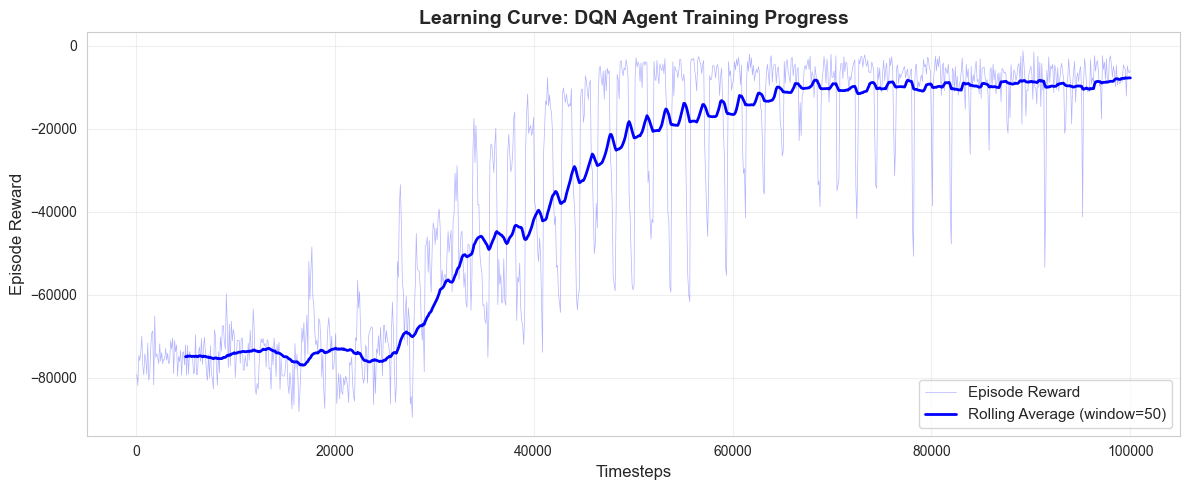


Training Statistics:
  Total Episodes: 1000
  Final Mean Reward (last 50 eps): -7755.02 ± 5656.22
  Best Episode Reward: -1188.00


In [7]:
# Learning Curve: Load training logs from Monitor wrapper
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.monitor import load_results
# Load monitor logs
monitor_df = load_results(str(LOG_DIR))
timesteps, episode_rewards = ts2xy(monitor_df, 'timesteps')

# Compute rolling average (window = 50 episodes)
WINDOW = 50
rolling_avg = np.convolve(episode_rewards, np.ones(WINDOW)/WINDOW, mode='valid')
rolling_timesteps = timesteps[WINDOW-1:]

# Plot Learning Curve
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(timesteps, episode_rewards, 'b-', linewidth=0.5, alpha=0.3, label='Episode Reward')
ax.plot(rolling_timesteps, rolling_avg, 'b-', linewidth=2, label=f'Rolling Average (window={WINDOW})')
ax.set_xlabel('Timesteps', fontsize=12)
ax.set_ylabel('Episode Reward', fontsize=12)
ax.set_title('Learning Curve: DQN Agent Training Progress', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTraining Statistics:")
print(f"  Total Episodes: {len(episode_rewards)}")
print(f"  Final Mean Reward (last {WINDOW} eps): {np.mean(episode_rewards[-WINDOW:]):.2f} ± {np.std(episode_rewards[-WINDOW:]):.2f}")
print(f"  Best Episode Reward: {np.max(episode_rewards):.2f}")

### 2. Exploration vs Exploitation
Epsilon decay over training timesteps.


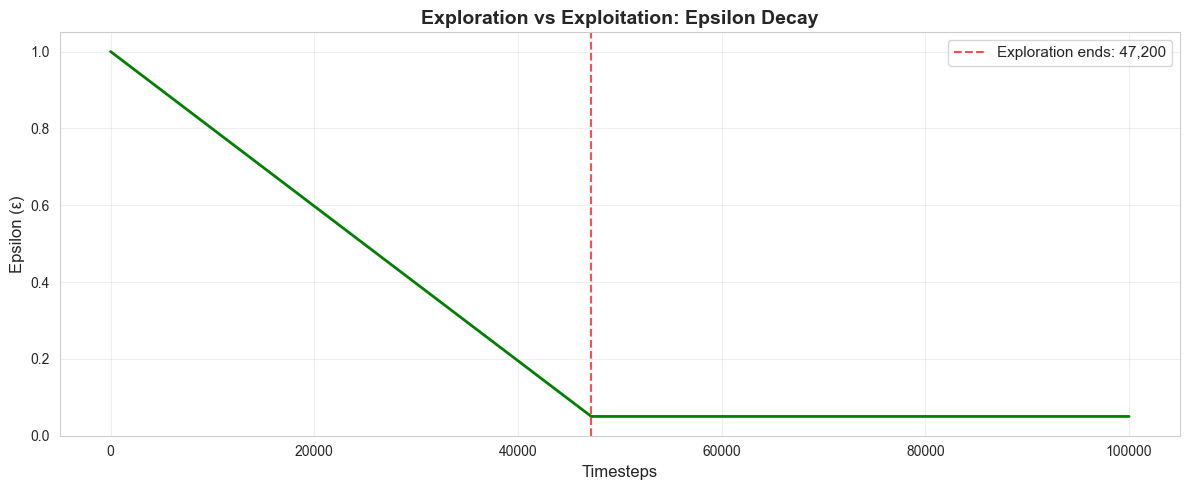

In [8]:
# Compute epsilon decay schedule
exploration_fraction = agent.hyperparams['exploration_fraction']
exploration_final_eps = agent.hyperparams['exploration_final_eps']
exploration_initial_eps = 1.0

timesteps = np.linspace(0, TOTAL_TIMESTEPS, 1000)
exploration_end = int(TOTAL_TIMESTEPS * exploration_fraction)

epsilon_values = []
for t in timesteps:
    if t < exploration_end:
        progress = t / exploration_end
        epsilon = exploration_initial_eps - progress * (exploration_initial_eps - exploration_final_eps)
    else:
        epsilon = exploration_final_eps
    epsilon_values.append(epsilon)

# Plot Epsilon Decay
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(timesteps, epsilon_values, 'g-', linewidth=2)
ax.axvline(x=exploration_end, color='r', linestyle='--', alpha=0.7, label=f'Exploration ends: {exploration_end:,}')
ax.set_xlabel('Timesteps', fontsize=12)
ax.set_ylabel('Epsilon (ε)', fontsize=12)
ax.set_title('Exploration vs Exploitation: Epsilon Decay', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
# Phase 2: Evaluation & Testing
Run N=100 independent test episodes with deterministic policy (ε=0).


In [9]:
# Cost parameters
K = 10   # Fixed ordering cost
i = 3    # Unit ordering cost
h = 1    # Holding cost per unit/day
pi = 7   # Shortage cost per unit/day

# Run N=100 test episodes with deterministic policy
N_TEST_EPISODES = 100

# Storage for test results
test_episodes_dqn = []

for ep in range(N_TEST_EPISODES):
    seed = 2000 + ep
    
    # DQN Agent Episode
    dqn_env = InventoryEnvironment(episode_length=EPISODE_LENGTH, random_seed=seed)
    obs, _ = dqn_env.reset()
    dqn_data = {'net_inv_0': [], 'net_inv_1': [], 'q0': [], 'q1': [], 
                'ordering_cost': 0, 'holding_cost': 0, 'shortage_cost': 0}
    done = False
    
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = dqn_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = dqn_env.step(action)
        
        dqn_data['net_inv_0'].append(info['net_inventory'][0])
        dqn_data['net_inv_1'].append(info['net_inventory'][1])
        dqn_data['q0'].append(action_obj.order_quantities[0])
        dqn_data['q1'].append(action_obj.order_quantities[1])
        
        # Compute cost components
        q0, q1 = action_obj.order_quantities
        inv0, inv1 = info['net_inventory']
        if q0 > 0: dqn_data['ordering_cost'] += K + i * q0
        if q1 > 0: dqn_data['ordering_cost'] += K + i * q1
        dqn_data['holding_cost'] += h * max(0, inv0) + h * max(0, inv1)
        dqn_data['shortage_cost'] += pi * max(0, -inv0) + pi * max(0, -inv1)
        
        done = terminated or truncated
    test_episodes_dqn.append(dqn_data)

print(f"✅ Collected {N_TEST_EPISODES} test episodes for DQN")

✅ Collected 100 test episodes for DQN


### 3. Cost Component Breakdown (Economic Analysis)
Grouped bar chart comparing DQN Agent vs. (s,S) Baseline decomposed into Ordering, Holding, and Shortage costs.


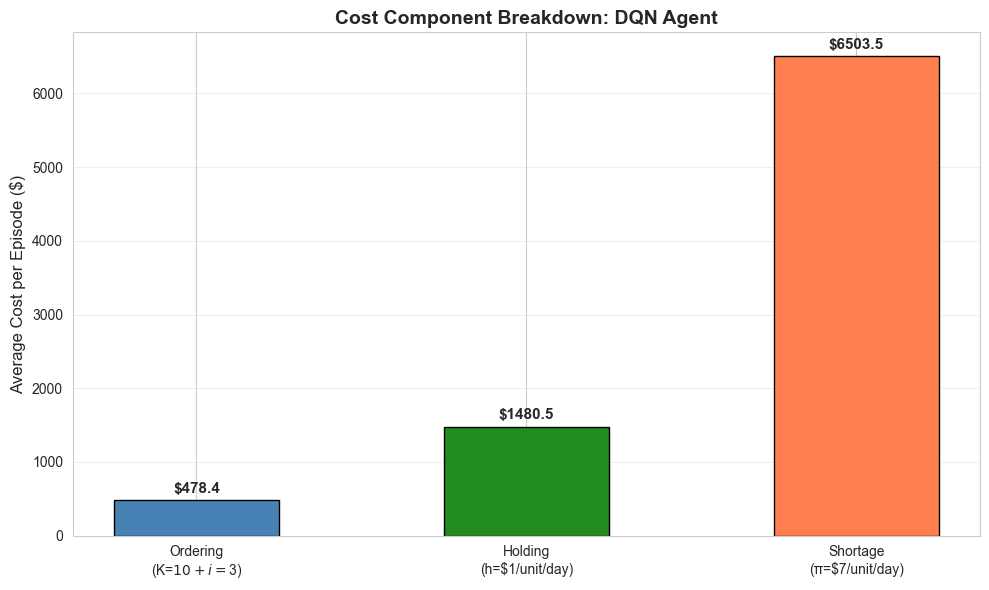


Total Average Cost per Episode: $8462.37
  Ordering: $478.40 (5.7%)
  Holding:  $1480.48 (17.5%)
  Shortage: $6503.49 (76.9%)


In [10]:
# Aggregate cost components
dqn_ordering = np.mean([ep['ordering_cost'] for ep in test_episodes_dqn])
dqn_holding = np.mean([ep['holding_cost'] for ep in test_episodes_dqn])
dqn_shortage = np.mean([ep['shortage_cost'] for ep in test_episodes_dqn])

# Plot Cost Component Breakdown
labels = ['Ordering\n(K=$10 + i=$3)', 'Holding\n(h=$1/unit/day)', 'Shortage\n(π=$7/unit/day)']
costs = [dqn_ordering, dqn_holding, dqn_shortage]
colors = ['steelblue', 'forestgreen', 'coral']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, costs, color=colors, width=0.5, edgecolor='black')

ax.set_ylabel('Average Cost per Episode ($)', fontsize=12)
ax.set_title('Cost Component Breakdown: DQN Agent', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'${height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print totals
total_cost = dqn_ordering + dqn_holding + dqn_shortage
print(f"\nTotal Average Cost per Episode: ${total_cost:.2f}")
print(f"  Ordering: ${dqn_ordering:.2f} ({dqn_ordering/total_cost*100:.1f}%)")
print(f"  Holding:  ${dqn_holding:.2f} ({dqn_holding/total_cost*100:.1f}%)")
print(f"  Shortage: ${dqn_shortage:.2f} ({dqn_shortage/total_cost*100:.1f}%)")

### 4. Operational Time Series (Behavioral Analysis)
Snapshot of 100 days showing Net Inventory and Replenishment Actions for Product 1 and Product 2.


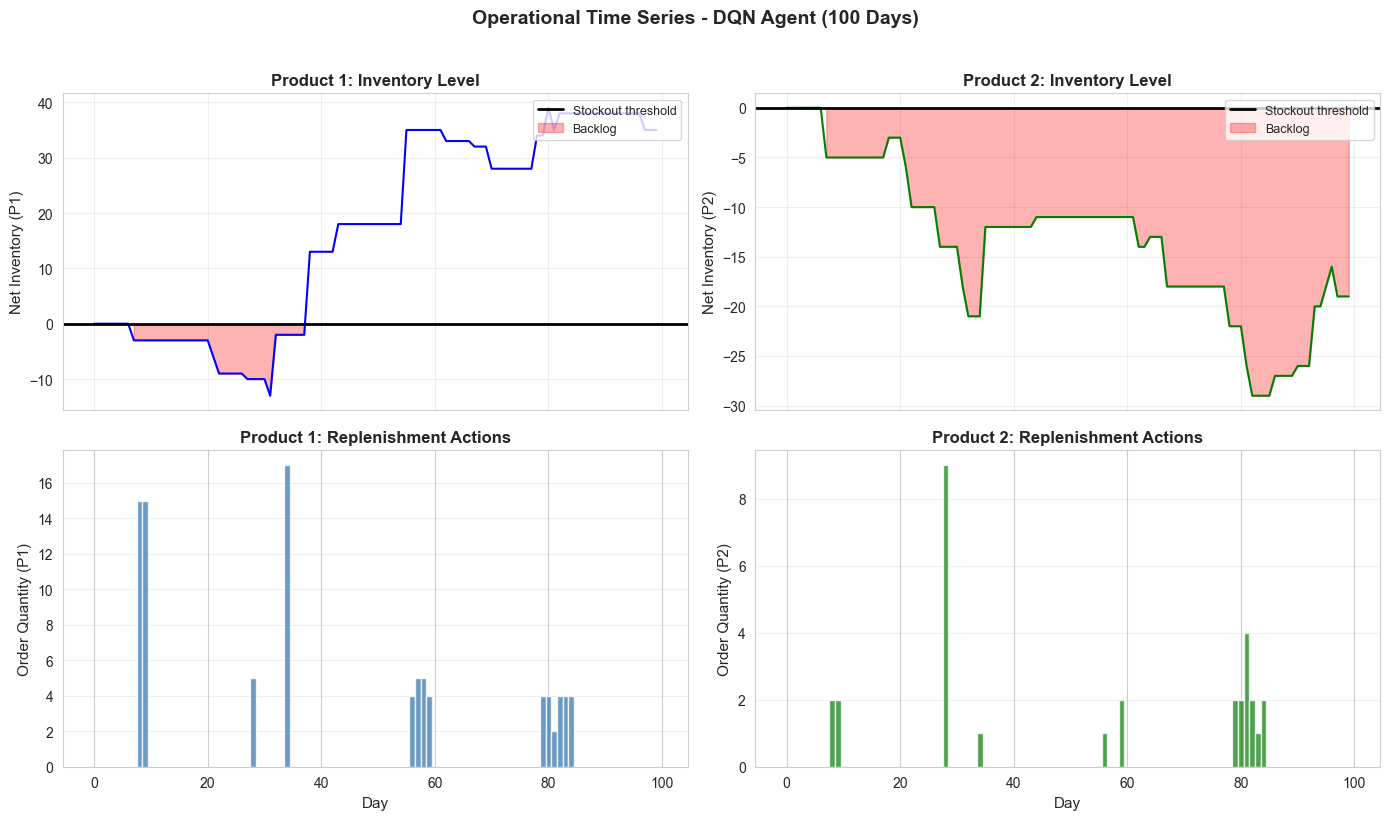

In [11]:
# Use first test episode for visualization
sample_ep = test_episodes_dqn[0]
days = np.arange(len(sample_ep['net_inv_0']))

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Product 1 - Net Inventory
ax = axes[0, 0]
ax.plot(days, sample_ep['net_inv_0'], 'b-', linewidth=1.5)
ax.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Stockout threshold')
ax.fill_between(days, sample_ep['net_inv_0'], 0, 
                where=[x < 0 for x in sample_ep['net_inv_0']], 
                color='red', alpha=0.3, label='Backlog')
ax.set_ylabel('Net Inventory (P1)', fontsize=11)
ax.set_title('Product 1: Inventory Level', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Product 1 - Replenishment Actions
ax = axes[1, 0]
ax.bar(days, sample_ep['q0'], color='steelblue', alpha=0.8, width=1.0)
ax.set_xlabel('Day', fontsize=11)
ax.set_ylabel('Order Quantity (P1)', fontsize=11)
ax.set_title('Product 1: Replenishment Actions', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Product 2 - Net Inventory
ax = axes[0, 1]
ax.plot(days, sample_ep['net_inv_1'], 'g-', linewidth=1.5)
ax.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Stockout threshold')
ax.fill_between(days, sample_ep['net_inv_1'], 0,
                where=[x < 0 for x in sample_ep['net_inv_1']],
                color='red', alpha=0.3, label='Backlog')
ax.set_ylabel('Net Inventory (P2)', fontsize=11)
ax.set_title('Product 2: Inventory Level', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Product 2 - Replenishment Actions
ax = axes[1, 1]
ax.bar(days, sample_ep['q1'], color='forestgreen', alpha=0.8, width=1.0)
ax.set_xlabel('Day', fontsize=11)
ax.set_ylabel('Order Quantity (P2)', fontsize=11)
ax.set_title('Product 2: Replenishment Actions', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Operational Time Series - DQN Agent (100 Days)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 5. Inventory Distribution Histogram (Risk Profile)
Distribution of Net Inventory levels over all test episodes. Red = Backlog (I < 0), Green = On-Hand (I > 0).


In [ ]:
# Collect all inventory levels across test episodes
all_inv_p1 = []
all_inv_p2 = []
for ep in test_episodes_dqn:
    all_inv_p1.extend(ep['net_inv_0'])
    all_inv_p2.extend(ep['net_inv_1'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Product 1 Histogram
ax = axes[0]
bins = np.linspace(min(all_inv_p1) - 5, max(all_inv_p1) + 5, 40)
n, bin_edges, patches = ax.hist(all_inv_p1, bins=bins, edgecolor='black', alpha=0.7)
# Color bars: red for negative, green for positive
for i, patch in enumerate(patches):
    bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
    patch.set_facecolor('red' if bin_center < 0 else 'green')
ax.axvline(x=0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Net Inventory Level', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Product 1: Inventory Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Backlog (I < 0)'),
                   Patch(facecolor='green', label='On-Hand (I > 0)')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Product 2 Histogram
ax = axes[1]
bins = np.linspace(min(all_inv_p2) - 5, max(all_inv_p2) + 5, 40)
n, bin_edges, patches = ax.hist(all_inv_p2, bins=bins, edgecolor='black', alpha=0.7)
for i, patch in enumerate(patches):
    bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
    patch.set_facecolor('red' if bin_center < 0 else 'green')
ax.axvline(x=0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Net Inventory Level', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Product 2: Inventory Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.suptitle('Inventory Distribution - Risk Profile (DQN Agent)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print service level stats
stockout_p1 = sum(1 for x in all_inv_p1 if x < 0) / len(all_inv_p1)
stockout_p2 = sum(1 for x in all_inv_p2 if x < 0) / len(all_inv_p2)
print(f"\nService Level (% days without stockout):")
print(f"  Product 1: {(1-stockout_p1)*100:.1f}%")
print(f"  Product 2: {(1-stockout_p2)*100:.1f}%")
